## Introduction

The purpose of this project is to compare rainfall patterns between Seattle, WA and Vancouver, Canada from 2018 to 2022.  
We want to determine which city receives more precipitation overall and examine seasonal patterns.




## Data Sources

- **Seattle rainfall data:** [seattle_rain.csv](https://github.com/brian-fischer/DATA-5100/blob/main/weather/seattle_rain.csv)  
- **Vancouver rainfall data:** Downloaded from [NOAA Climate Data Online](https://www.ncei.noaa.gov/cdo-web/)  

These datasets include daily precipitation records. Some data cleaning is required before analysis.


In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [402]:
#load data 
seattle_df = pd.read_csv("../data/seattle_rain.csv")
vancouver_df = pd.read_csv("../data/vancouver_rain.csv")


In [ ]:
# Inspect data
display(seattle_df.head())
display(vancouver_df.head())
display(seattle_df.info())
display(vancouver_df.info())

,date,vancouver_precipitation
0,2018-01-01,0.00
1,2018-01-02,0.00
2,2018-01-03,0.00
3,2018-01-04,0.00
4,2018-01-05,0.06


,date,seattle_precipitation
0,2018-01-01,0.00
1,2018-01-02,0.00
2,2018-01-03,0.00
3,2018-01-04,0.00
4,2018-01-05,0.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1531 non-null   datetime64[ns]
 1   vancouver_precipitation  1531 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.1 KB


None

The Seattle dataset has columns `DATE` and `PRCP` representing daily rainfall.  
The Vancouver dataset has a similar structure. No major anomalies are observed, but some missing values exist that will be handled in the next step.


### Clean and Prepare data


In [ ]:
#Rename Column for clarity
seattle_df.rename(columns={'PRCP':'seattle_precipitation', 'DATE' : 'date'}, inplace= True)
vancouver_df.rename(columns={'PRCP':'vancouver_precipitation','DATE': 'date'}, inplace= True)


,date,vancouver_precipitation
0,2018-01-01,0.0
1,2018-01-02,0.0
2,2018-01-03,0.0


In [497]:
#Convert data columns to datetime type
seattle_df['date'] = pd.to_datetime(seattle_df['date'])
vancouver_df['date'] = pd.to_datetime(vancouver_df['date'])


In [498]:
# Remove duplicate rows if any
seattle_df = seattle_df.drop_duplicates()
vancouver_df = vancouver_df.drop_duplicates()

# Filter datasets to only include dates between 2018-01-01 and 2022-12-31
start_date = '2018-01-01'
end_date = '2022-12-31'

seattle_df = seattle_df[(seattle_df['date'] >= start_date) & (seattle_df['date'] <= end_date)]
vancouver_df = vancouver_df[(vancouver_df['date'] >= start_date) & (vancouver_df['date'] <= end_date)]


In [499]:
#Select only date and precipitation columns
seattle_df = seattle_df[['date', 'seattle_precipitation']]
vancouver_df = vancouver_df[['date', 'vancouver_precipitation']]

The datasets are now consistent in format, filtered to the analysis period, and ready for merging

## Merge and Reshape data

In [ ]:
#Merge dataset
combine_city = pd.merge(seattle_df, vancouver_df, on = 'date')

#rename column 
combine_city.rename(columns={'precipition_x':'seattle_precipitation','precipition_y':'vancouver_precipitation'})




,date,seattle_precipitation,vancouver_precipitation
0,2018-01-01,0.00,0.00
1,2018-01-02,0.00,0.00
2,2018-01-03,0.00,0.00
3,2018-01-04,0.00,0.00
4,2018-01-05,0.25,0.06


In [ ]:
# Ensure that the data frame is in a tidy, or long, format.
tidy_df = combine_city.melt(id_vars='date', 
                            value_vars=['seattle_precipitation', 'vancouver_precipitation'],
                            var_name='city', 
                            value_name='precipitation')

# Clean up city names
tidy_df['city'] = tidy_df['city'].replace({
    'seattle_precipitation': 'Seattle',
    'vancouver_precipitation': 'Vancouver'
})

# Create a month column
tidy_df['month'] = tidy_df['date'].dt.to_period('M')
tidy_df['year'] = tidy_df['date'].dt.year



The data is now tidy with columns: date, city, precipitation, and month. This format simplifies monthly aggregation and visualization.

## Handling missing months

In [ ]:

# Group by city and month to get total monthly rainfall
monthly_rainfall = tidy_df.groupby(['city', 'month'])['precipitation'].sum().reset_index()

# Create all combinations of city and month
all_months = pd.period_range(start=monthly_rainfall['month'].min(), end=monthly_rainfall['month'].max(), freq='M')
cities = monthly_rainfall['city'].unique()
all_combinations = pd.MultiIndex.from_product([cities, all_months], names=['city', 'month'])

# Reindex to include missing months
monthly_rainfall = monthly_rainfall.set_index(['city','month']).reindex(all_combinations).reset_index()


#Fill missing precipitation values with the mean of each city
monthly_rainfall['precipitation'] = monthly_rainfall.groupby('city')['precipitation'].transform(
    lambda x: x.fillna(x.mean())
)
# rename column for clarity
monthly_rainfall.rename(columns={'precipitation': 'monthly_total'}, inplace=True)



All months now have precipitation values. For example, the missing February 2018 in Seattle is replaced with the city’s average monthly precipitation.

## Derived Variables

In [517]:
# Count rainy days per month
monthly_rainfall['is_rain'] = monthly_rainfall['monthly_total'].apply(lambda x: 1 if x > 0 else 0)

monthly_rainfall.head()

,city,month,monthly_total,is_rain,month_str,year
0,Seattle,2018-01,1.460000,1,2018-01,2018
1,Seattle,2018-02,2.919273,1,2018-02,2018
2,Seattle,2018-03,1.460000,1,2018-03,2018
3,Seattle,2018-04,5.390000,1,2018-04,2018
4,Seattle,2018-05,0.010000,1,2018-05,2018


We have monthly_total (total precipitation per month) and is_rain (indicator for rainy days) for each city.

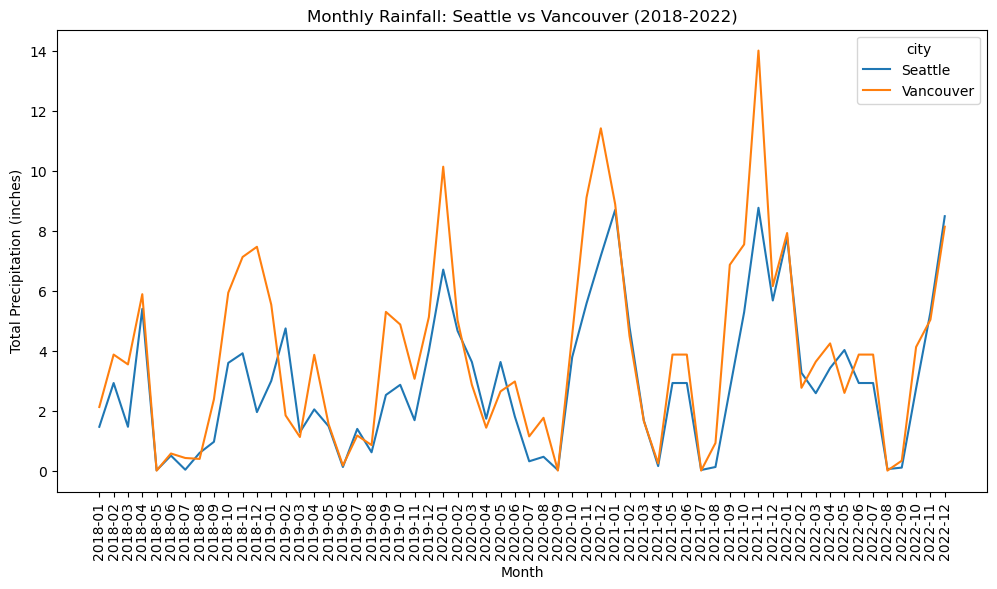

In [514]:
#plot monthly rainfall
# Convert month to string for plotting
monthly_rainfall['month_str'] = monthly_rainfall['month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_rainfall, x='month_str', y='monthly_total', hue='city')
plt.title('Monthly Rainfall: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (inches)')
plt.xticks(rotation=90)
plt.show()



* Vancouver generally has more rainy days than Seattle, especially in the late fall and winter (October–March).

* Seattle’s highest rainy month is October 2021, while Vancouver peaks in October 2021.

* October 2021 showed the biggest gap, with Vancouver much wetter than Seattle.

* Both cities have peaks in late fall/winter (Oct–Feb) and lows in summer (Jun–Aug).

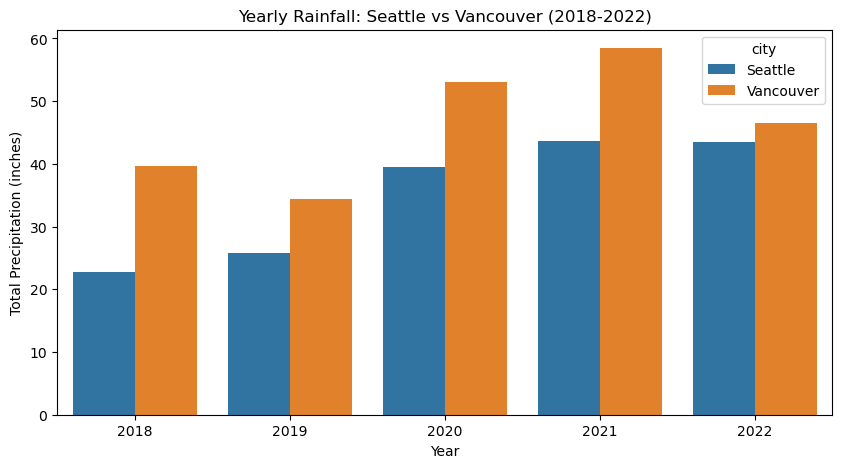

In [516]:
# Extract year from month
monthly_rainfall['year'] = monthly_rainfall['month'].dt.year

# Aggregate yearly precipitation
yearly_rain = monthly_rainfall.groupby(['city', 'year'])['monthly_total'].sum().reset_index()
yearly_rain.rename(columns={'monthly_total': 'yearly_precipitation'}, inplace=True)

# Bar plot
plt.figure(figsize=(10,5))
sns.barplot(data=yearly_rain, x='year', y='yearly_precipitation', hue='city')
plt.title('Yearly Rainfall: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (inches)')
plt.show()


* Over 5 years Vancouver has the highest rain and Vancouver typically adds 10-15 inches more rain than seattle each year.
* Both cities saw a sharp increase from 2019 to 2020.